# Decoder Transformer

In this section of the course we want to look at training our own Transformers. We provide you with an easy to follow and adapt workflow and show you the typical pitfals most blog posts and books do not mention.

Last session, we introduced the Encoder-only Transformer and this time we take a look at the Decoder-only Transformer to build a  model that can write book reviews given a prompt - e.g text to text.

## The Decoder-only Transformer

An Decoder Transformer esentially reads an entire text and predicts the next token. That means it "prolongs" an existing text. This might sound different than writing a review from a prompt but imagine the following text:

*We saw white sheep in New Zealand and England. There are white sheep in Germany and the Netherlands, too. Only in Canada we encountered a brown sheep. Therefore, we assume that*

How would you complete the sentence? Obviously there are many choices:

1.   *we should visit more places to see what color sheeps have there.*
2.   *most sheeps are white.*

Both options are highly conditioned on the prior text and that makes sense for a book review based on a prompt, too.

### The Decoder Data-Flow

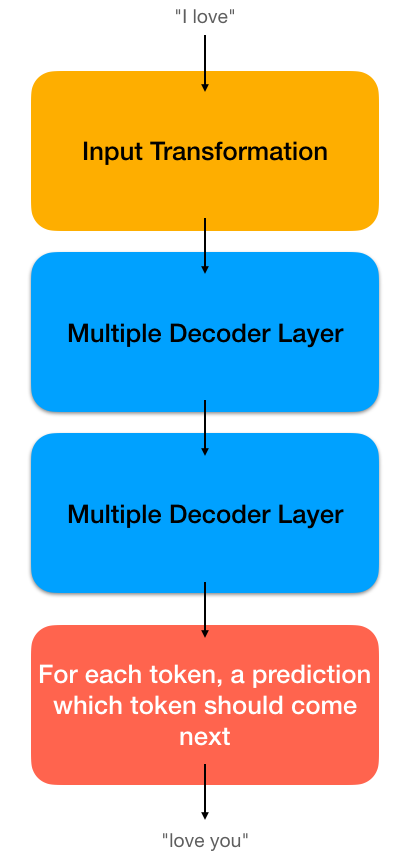

### The Input Transformation
Is exactly the same schema as for the Encoder only transfomer!

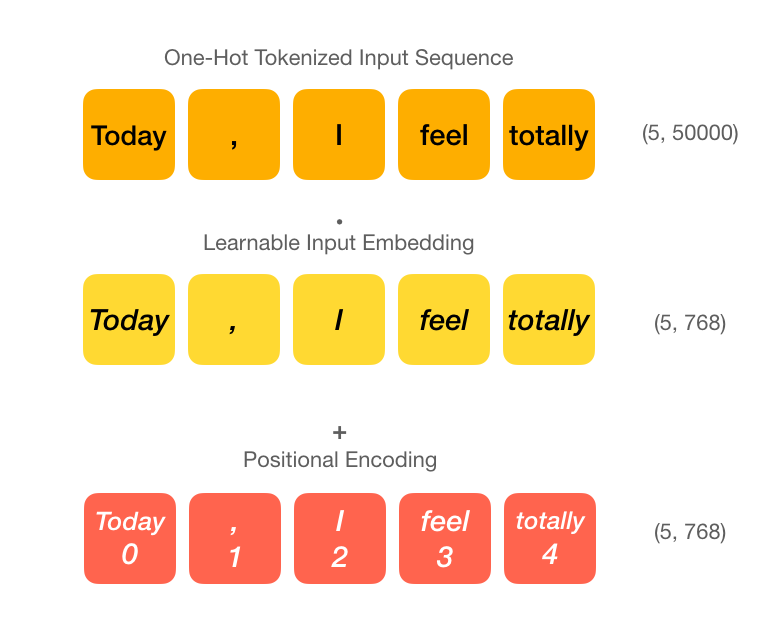

### The Decoder Layer(s)

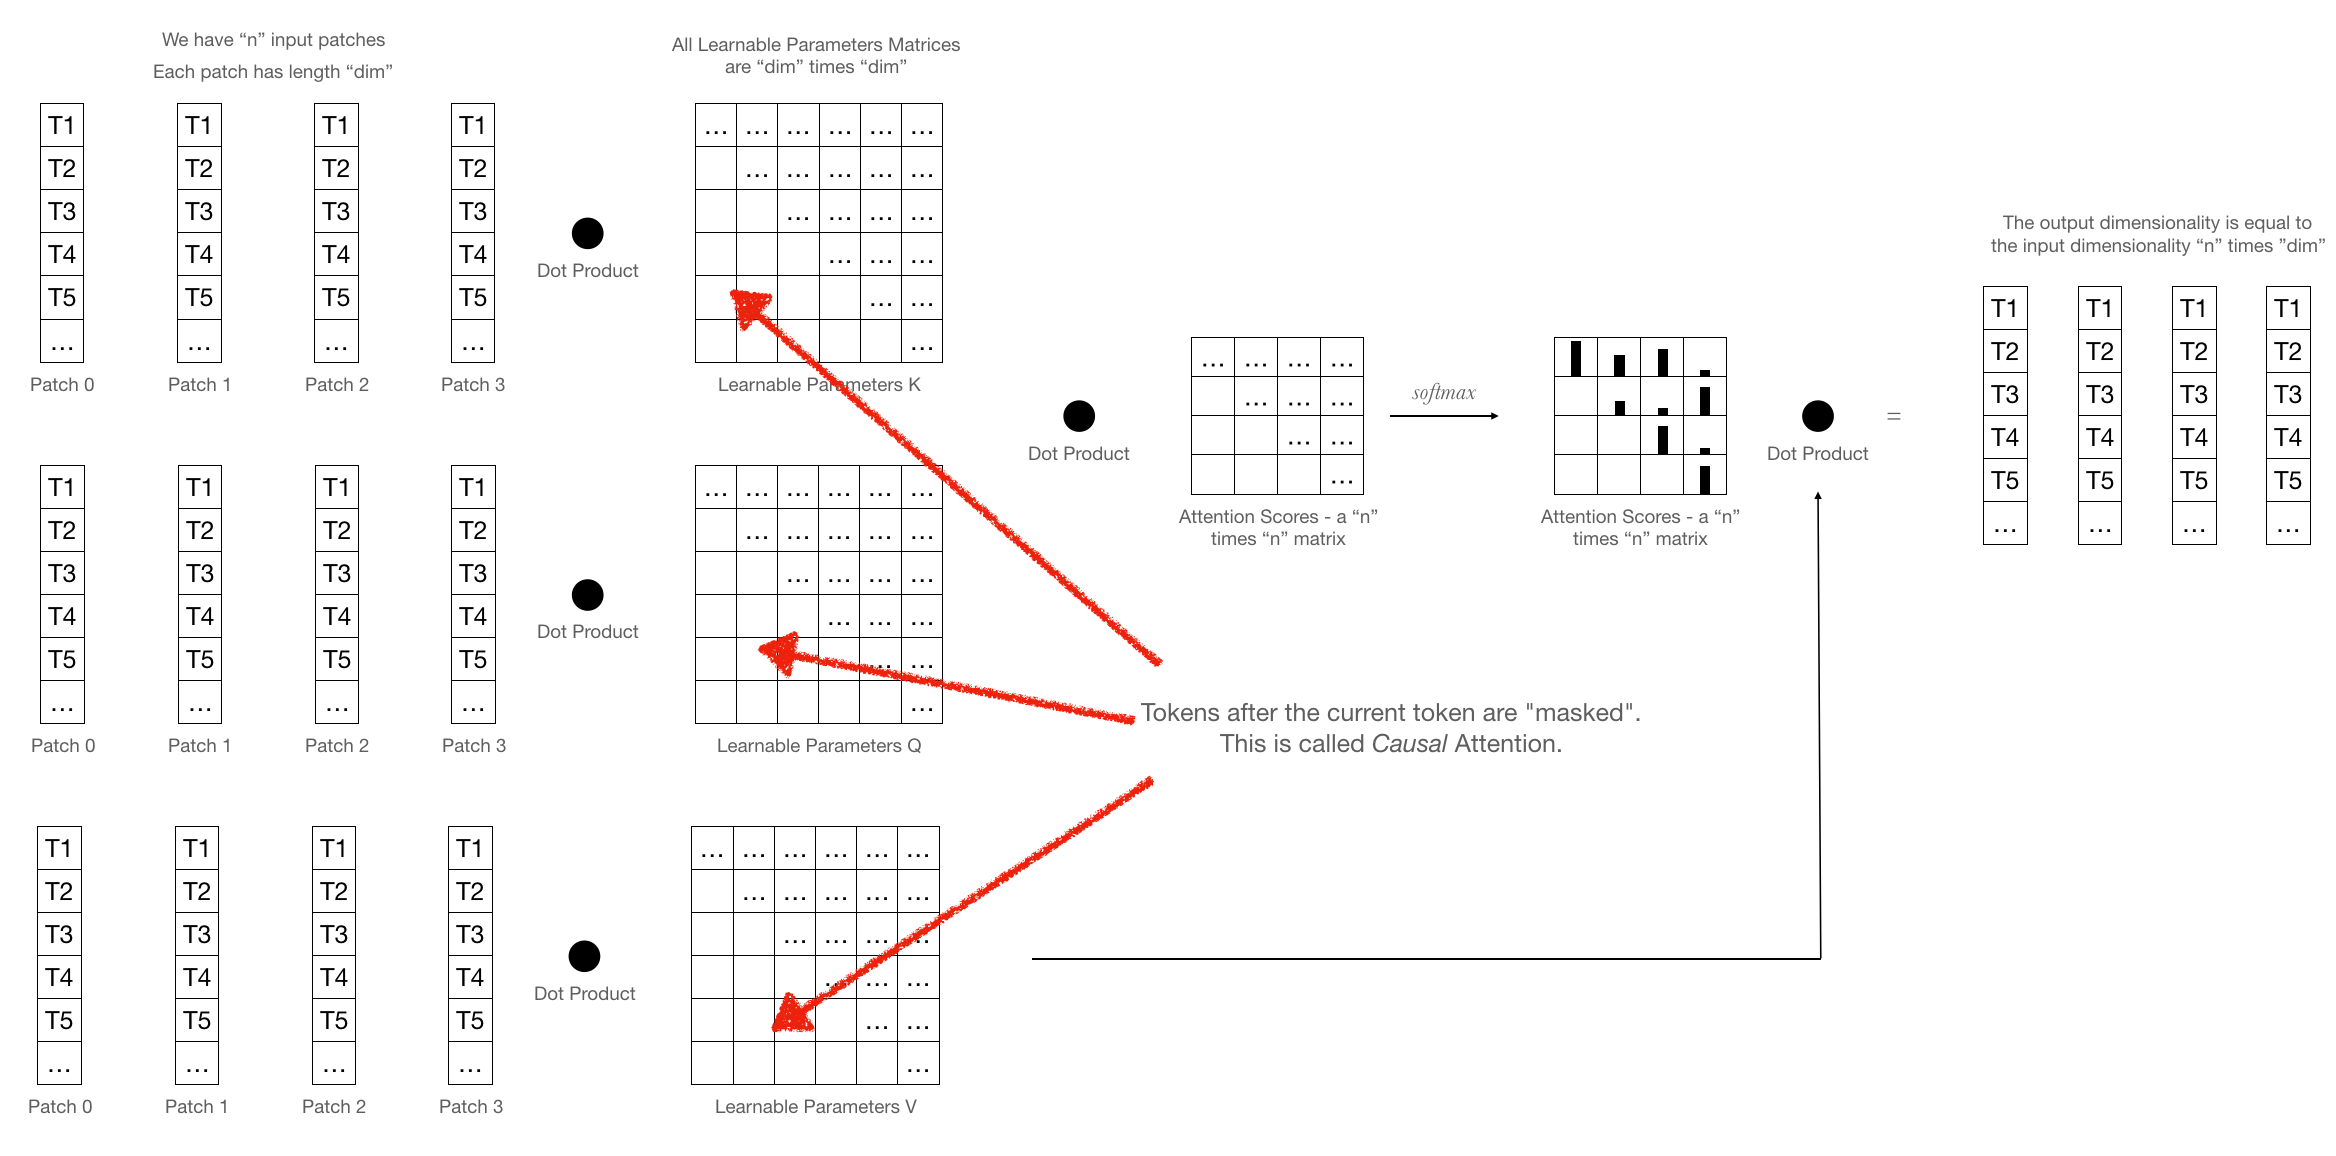

### Ouput Tasks

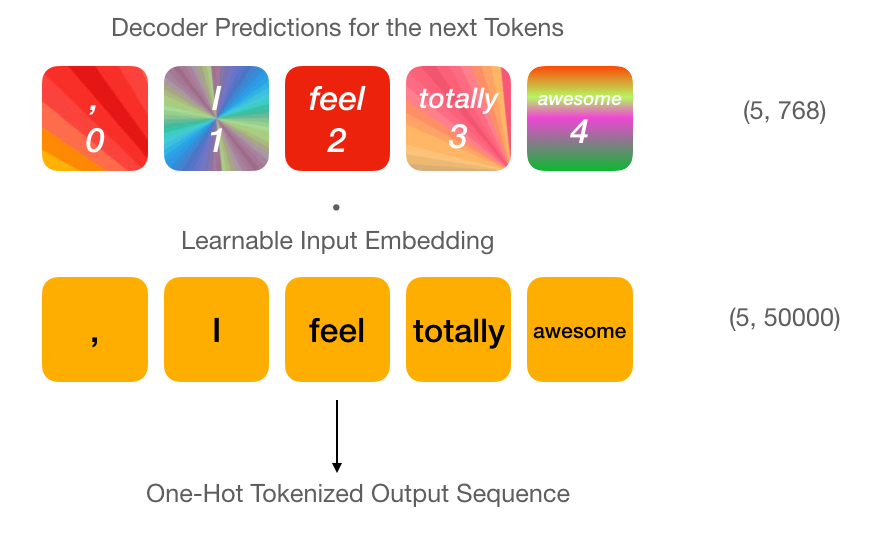

## Setup

In [ ]:
# Setup
# This cell installs all the dependencies used in this week - imports happen as we go
%%capture

!pip install transformers datasets langchain sentence-transformers accelerate python-dotenv xformers openai faiss-cpu tiktoken

# Training and using a Decoder Transformer

Let's get started writing book reviews - we use the famous Amazon review dataset and reuse the cool streaming feature of the datasets objects introduced last session.

## Data Exploration - Create Your own Book reviews

In [ ]:
# Load the dataset and buffer the first 200 shuffled
from datasets import load_dataset


amazon_us_reviews = load_dataset("till0r/nlp-in-5-weeks-reviews", streaming=True, split='train', name="Books_v1_02")
shuffled_amazon_us_reviews = amazon_us_reviews.shuffle(seed=42, buffer_size=200)

In [ ]:
# We can use itertools again to gather the first n records from the streaming iterator
import itertools

N = 200
amazon_us_reviews_sample = list(itertools.islice(iter(shuffled_amazon_us_reviews), N))

In this section we want to show you how to convert a pandas DataFrame to a Huggingface Dataset. That might be handy for your daily work.

In [ ]:
import pandas as pd


df = pd.DataFrame(amazon_us_reviews_sample)
df

First, we need to design a prompt that is followed by the review.

In [ ]:
def create_prompt(row):
    return f"Write a {row['star_rating']} for {row['product_title']}: {row['review_body']}"

In [ ]:
# We can use Pandas apply to create a new column from create_prompt using existing columns
df["input"] = df.apply(create_prompt, axis=1)

As we have discuessed the Attention mechanism has a limited context length due to computational complexity and the trained positional encodings of a pretrained model would not exist for the new sequence positions.

If you train a model from scratch it is just a simple parameter - [see here for the config of GPT-2 in HuggingFace.](https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/gpt2#transformers.GPT2Config) The parameter is called "n_positions".
[
Therefore, keeping an eye on the length of your texts is important.

In [ ]:
# We have some very long reviews in this dataset
df["input"].str.len().plot.hist()

Let's imagine we have this dataset stored as a parquet file or need to store it. Pandas has built in Parquet support.

In [ ]:
# Write parquet
df.to_parquet("df.parquet")

In [ ]:
# Read parquet
df = pd.read_parquet("df.parquet")

#### Two ways to achive the same result

Now, we need to convert the DataFrame to a Huggingface dataset. There are two ways to achive exactly the same result here.

In [ ]:
# Option A - use a train-split defined somewehere else
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Let's assume we have a given train-test split and therefore two Pandas DataFrames
train_df, valid_df = train_test_split(df, test_size=0.15, random_state=42)

# We can create two individual Huggingface Datasets
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)

# And combine them to a DatasetDict
ds = DatasetDict()

ds['train'] = train_ds
ds['valid'] = valid_ds
ds

In [ ]:
# Option B - we let Huggingface do the train-test-split
from datasets import Dataset

# This automatically created a DatasetDict
ds = Dataset.from_pandas(df).train_test_split(test_size=0.15)
ds

## Using a Decoder Transformer

You can read more about GPT-2 in [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), which is its accompanying paper.


In [ ]:
# Loading the Model and Tokenizer is as simple as with the Encoder models
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# We have to pass this model a few extra parameters
model = GPT2LMHeadModel.from_pretrained("gpt2",
                                  bos_token_id=tokenizer.bos_token_id,
                                  eos_token_id=tokenizer.eos_token_id,
                                  scale_attn_by_inverse_layer_idx=True,
                                  reorder_and_upcast_attn=True)

In [ ]:
# Remember this code to see the size of a model
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f} Million parameters")

GPT-2 uses a different Encoder than BERT, but the idea is the same. Split parts of a word into tokens and maximze compression on the training dataset. With the GPT-2 BytePair Encoder the split does not happen on character, but on Unicode Byte Level.

In [ ]:
tokenizer(ds["train"][0]["review_body"])

Byte-level BytePair Encoding is very powerful, because it can represent any text.

In [ ]:
tokenizer("🛒✈️")

Have you wondered how the model learns to stop predicting? There is a special Token for that. Note, that the Tokens of BERT and GPT-2 are not the same.

In [ ]:
# Can you spot the id of the <|endoftext|> token?
tokenizer(ds["train"][0]["review_body"] + '<|endoftext|>')

To keep things fast in our limited time, we reduce the maximum length of the texts to 500 tokens.

In [ ]:
context_length = 500

It's a good practice to write a preprocessing function that does all the necessary changes to strings and tokens your usecase requires. Here we are truncating the encoded texts and add the <|endoftext|> token.

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        [item + '<|endoftext|>' for item in element["input"]],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=False,
        return_length=True
    )


    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        input_batch.append(input_ids + [tokenizer.eos_token_id])


    return {"input_ids": input_batch}

Again, we use the Hugginface Dataset map method to tokenize all splits of the Dataset.

In [ ]:
tokenized_ds = ds.map(
    tokenize, batched=True, remove_columns=ds["train"].column_names
)

## Learn to Use the Hugging Face Trainer

If you thought there is no object from Huggingface coordinating the training you are wrong. The Huggingface Trainer is one of the best Training coordinators available and supports a huge range of options.

When using the Huggingface Trainer we need a Huggingface Data Collator that connects the Trainer to the Dataset. The Data Collator has two main jobs: Batch the Dataset and apply necessary functions to prepare the batch - like padding - e.g. adding special tokens to shorter sequences so that all sequences are the same length within a batch. This is necessay for GPU usage.


In [ ]:
# Of course there is a special Data Collator for exactly his task
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
# Let's see the shapes of the first 5 records when run through the Data Collator
out = data_collator([tokenized_ds["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

A Huggingface trainer needs Training Arguments that describe the Hyperparameters of the Training as well as the loss computation and all aspects of logging and saving of models. It even offers additional features that make training on multiple GPUs or smaller GPUs easier:



1.   Gradient Accumulation
2.   Multi GPU Usage via Distributed Data Parallel


Training a model on the full dataset might take a long time with Google Colab free tier. After this short training we will provide you with a way to load a model trained by us.

In [ ]:
from transformers import Trainer, TrainingArguments


args = TrainingArguments(
    output_dir="gpt2-book-reviews",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    eval_steps=6,
    logging_steps=6,
    gradient_accumulation_steps=8,
    num_train_epochs=4,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=6,
    load_best_model_at_end=True,
    save_total_limit=4
    #fp16=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"]
)

In [ ]:
trainer.train(resume_from_checkpoint=False)

In [ ]:
# Let's try the results of this mini trainig
# First, we tokenize the prompt
tokenized = tokenizer("Write a 5 star review for Harry Potter and the sorcerer Stone:", return_tensors="pt")

# Then, we let the model run multiple times though the generate method until
# it encoutners a <|endoftext|> or reaches a deined max_length
generated =  model.generate(input_ids=tokenized["input_ids"].cuda(),
                            attention_mask=tokenized["attention_mask"].cuda(),
                            max_length=context_length, temperature=0.7,
                            early_stopping=True,
                            do_sample=True)

In [ ]:
# Now we just have to decode the tokens to characters
tokenizer.batch_decode(generated, skip_special_tokens=True)

In [ ]:
# If you want to, you can load our model here
model = GPT2LMHeadModel.from_pretrained("till0r/nlp-in-5-weeks-gpt2")
model = model.cuda()

# Using openAI's API (or local HuggingFace models) in LangChain

In this section we will make use of the LangChain library. LangChain is a popular but often criticised abstraction layer around common tools used with LLMs. While its longterm development might be unsure, it is the perfect starting poing for beginners right now!


It's main focus is the OpenAI LLM offering, but other models such as HuggingFace models can be used, too.


## Choosing an LLM

In [ ]:
# Setup - choose your desired LLM provider
api = "openai"  # "huggingface"

In [ ]:
from dotenv import load_dotenv
import os

os.environ["OPENAI_API_KEY"] = ""


# Loads a file and dumps its context into the os environment variables
load_dotenv("env")

In [ ]:
from langchain.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain.llms import OpenAI
import os


# Loads a file and dumps its context into the os environment variables
load_dotenv("env")


if api == "openai":
    model = OpenAI(temperature=0.5)

# You can use any huggingface text-generation or text-to-text
elif api == "huggingface":
    model_id = "gpt2"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model = AutoModelForCausalLM.from_pretrained(model_id)
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=200, temperature=0.5)


    model = HuggingFacePipeline(pipeline=pipe)

In [ ]:
from langchain.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate.from_template(template)

chain = prompt | model

question = "What is electroencephalography?"

print(chain.invoke({"question": question}))

## Batch Generation with HuggingFace

In [ ]:
if api == "huggingface":
    gpu_llm = HuggingFacePipeline.from_model_id(
        model_id="bigscience/bloom-1b7",
        task="text-generation",
        device=0,  # -1 for CPU
        batch_size=2,  # adjust as needed based on GPU map and model size.
        model_kwargs={"temperature": 0, "max_length": 64},
    )

    gpu_chain = prompt | gpu_llm.bind(stop=["\n\n"])

    questions = []
    for i in range(4):
        questions.append({"question": f"What is the number {i} in french?"})

    answers = gpu_chain.batch(questions)
    for answer in answers:
        print(answer)

# Emulating Week 2's classifier with LangChain

Hands-On: Use the HuggingFace dataset API to access large datasets and OpenAI’s API or a HuggingFace model through the langchain library to quickly setup a generative LLM in-context-learning pipeline. Improve the solution by applying latent space search introduced in Week 2.


In [ ]:
from langchain.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import AutoTokenizer, pipeline
import torch

if api == "huggingface":
    model_id = "PY007/TinyLlama-1.1B-intermediate-step-715k-1.5T"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    pipe = pipeline(
        "text-generation",
        model=model_id,
        torch_dtype=torch.float16,
        device_map="auto",
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        repetition_penalty=1.5,
        eos_token_id=tokenizer.eos_token_id,
        max_length=500,
    )

    model = HuggingFacePipeline(pipeline=pipe)

In [ ]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.chat_models import ChatOpenAI

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

### About prompt engineering

In [ ]:
model = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("{prompt}")
#prompt = ChatPromptTemplate.from_template("This is a sentiment analysis request. What is the sentiment of the following text? {prompt}")

In [ ]:
functions = [
    {
        "name": "sentiment",
        "description": "Summarizes the sentiment of the given text.",
        "parameters": {
            "type": "object",
            "properties": {
                "sentiment": {
                    "type": "string",
                    "description": "Can either be positive, negative or neutral.",
                },
            },
            "required": ["sentiment"],
        },
    }
]

In [ ]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

chain = (
    prompt
    | model.bind(function_call={"name": "sentiment"}, functions=functions)
    | JsonOutputFunctionsParser()
)

In [ ]:
for prompt in ["This restaurant is awesome!", "This restaurant is awful!"]:
    print(prompt)
    print(chain.invoke({"prompt": prompt}))

# Putting it all together - RAG (Retrival Augmented Generation)

The RAG pattern is older then you might think - see the original papaer from 2020: [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks](https://arxiv.org/pdf/2005.11401.pdf)



Please download a Plain Text UTF-8 a copy of [The War of the Worlds by H. G. Wells](https://www.gutenberg.org/ebooks/36).


In [ ]:
from langchain.document_loaders import TextLoader

loader = TextLoader("pg36.txt")
doc = loader.load()
print(f"You have {len(doc)} document")
print(f"You have {len(doc[0].page_content)} characters in that document")

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=400)
docs = text_splitter.split_documents(doc)

# Get the total number of characters so we can see the average later
num_total_characters = sum([len(x.page_content) for x in docs])

print(
    f"Now you have {len(docs)} documents that have an average of {num_total_characters / len(docs):,.0f} characters (smaller pieces)"
)

In [ ]:
from operator import itemgetter

from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough


vectorstore = FAISS.from_documents(
    docs, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI()

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("What weapons do the invaders utilize?")

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}

Answer in the following language: {language}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke({"question": "What weapons do the invaders utilize?", "language": "german"})

# Summary


We hope you enjoyed this course - let's quickly recap what you have seen in these three weeks.



1.   A short recap of NLP history and the problems each "epoch" had
2.   Symbolic and Statistical methods to work with language
3.   How the idea of a word embedding changed everything
4.   How transformer models work on embeddings
5.   Encoder and Decoder transformers
6.   How a transformer can be task specific
7.   How generative transformers can work around task limitations through in context learning

